<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/06_insurance_federated_cv_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Insurance - a Federated Learning Use Case.

Wrapup

## Setup
---

In [6]:
# Is a repo-clone and installs needed (e.g. in colabs)? 
need_clone_install = True

### Pull Repo

In [7]:
if need_clone_install:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

Cloning into 'fl-official-statistics-addon'...
remote: Enumerating objects: 938, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 938 (delta 81), reused 14 (delta 10), pack-reused 818
Receiving objects: 100% (938/938), 34.69 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (441/441), done.
/content/fl-official-statistics-addon/fl-official-statistics-addon
Already up to date.


### Installs

In [8]:
#if need_clone_install: 
  #!pip install --quiet nest_asyncio==1.5.6
  #!pip install --quiet tensorflow_federated==0.20.0
  #!pip install --quiet tensorflow_addons==0.20.0
  # or !pip install -r requirements.txt

# save with: !pip freeze > requirements.txt
!python --version

Python 3.10.11


### Imports

In [9]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
#import tensorflow_federated as tff
#from tensorflow_addons.metrics import RSquare
#import tensorflow_addons as tfa
#import nest_asyncio
from sklearn.metrics import r2_score

np.random.seed(0)

## Ingestion and data split
---

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


### Train-Test-Split

Cross Validation s. 
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 

In [11]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [12]:
#nfolds = 5
#cv = StratifiedKFold(n_splits = nfolds, random_state = 42, shuffle= True)
#ind = 0
#for train, test in cv.split(df, df.region):
#  ind += 1
#  df.loc[train, 'fold' + str(ind)] = 'train'
#  df.loc[test,  'fold' + str(ind)] = 'test'


In [13]:
nfolds = 5
nreps = 2
cv = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
ind = 0
for train, test in cv.split(df, df.region):
  
  label = 'rep' + str(int(np.floor(ind / nfolds))) + '-fold' + str(ind % nfolds)
  df.loc[train, label] = 'train'
  df.loc[test,  label] = 'test'
  ind += 1

In [14]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'region0', 'region1', 'region2', 'region3', 'rep0-fold0', 'rep0-fold1',
       'rep0-fold2', 'rep0-fold3', 'rep0-fold4', 'rep1-fold0', 'rep1-fold1',
       'rep1-fold2', 'rep1-fold3', 'rep1-fold4'],
      dtype='object')

In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,...,rep0-fold0,rep0-fold1,rep0-fold2,rep0-fold3,rep0-fold4,rep1-fold0,rep1-fold1,rep1-fold2,rep1-fold3,rep1-fold4
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,...,train,train,train,test,train,test,train,train,train,train
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,...,train,train,train,train,test,train,train,train,train,test
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,...,train,train,train,test,train,train,train,train,test,train
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,...,train,train,train,test,train,train,train,train,train,test
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,...,train,train,test,train,train,test,train,train,train,train


#### Check

Check of the train test ratios for each region and fold.

In [16]:
ptrains = []
rep = 1

for fold in range(nfolds):
  label = 'rep'+ str(rep) +'-fold' + str(fold)
  ntrain = sum(df[label] == 'train')
  ntest = sum(df[label] == 'test')
  ptrain = ntrain / (ntrain + ntest); ptrains.append(ptrain)
  print(
      '(region, fold) =  (%s, %s), ntrain = %s, ntest = %s, ptrain = %.2f %%' %
      ('combined', fold, ntrain, ntest, ptrain * 100)
  )
print('=============================================================================')
for region in df.region.unique():
  for fold in range(5):
    df_temp = df[df.region == region]
    ntrain  = sum(df_temp[label] == 'train')
    ntest   = sum(df_temp[label] == 'test')
    ptrain  = ntrain / (ntrain + ntest); ptrains.append(ptrain)
    print(
        '(region, fold) = (%s, %s), ntrain =  %s, ntest =  %s, ptrain = %.2f %%' %
        (region, fold, ntrain, ntest, ptrain * 100)
    )


(region, fold) =  (combined, 0), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 1), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 2), ntrain = 1070, ntest = 268, ptrain = 79.97 %
(region, fold) =  (combined, 3), ntrain = 1071, ntest = 267, ptrain = 80.04 %
(region, fold) =  (combined, 4), ntrain = 1071, ntest = 267, ptrain = 80.04 %
(region, fold) = (southwest, 0), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 1), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 2), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 3), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southwest, 4), ntrain =  260, ntest =  65, ptrain = 80.00 %
(region, fold) = (southeast, 0), ntrain =  292, ntest =  72, ptrain = 80.22 %
(region, fold) = (southeast, 1), ntrain =  292, ntest =  72, ptrain = 80.22 %
(region, fold) = (southeast, 2), ntrain =  292, ntest =  72, ptr

## Model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer


def build_model(units = [40, 40, 20], activations = ['relu'] * 3, input_shape = [9]):
  model = Sequential()
  model.add(InputLayer(input_shape = input_shape))
  for ind in range(len(units)):
    model.add(Dense(units = units[ind], activation = activations[ind]))
  model.add(Dense(1))
  return model

build_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                400       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


## Centralized neural networks
---

### Training

In [18]:
# inputs
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

In [79]:
# helpers
def train_model(X_train, y_train, epochs = 100, seed = 42, verbose = 0):
  
  # generate a model
  model = build_model(input_shape = [X_train.shape[1]])
  model.compile(
        loss = 'mean_squared_error', 
        optimizer = tf.optimizers.Adam(learning_rate = .05),
        # <- Adam + lower learning rate
        metrics = ["mae", 'mean_squared_error', r2_score], 
        run_eagerly = True
        )

  # train 
  tf.random.set_seed(seed)
  rtime = time.time() 
  with tf.device('/device:GPU:0'):
    hist = model.fit(
        X_train, y_train,
        batch_size = 128, 
        # <- higher batch_size
        shuffle = True,
        validation_split = 0.2,
        epochs = epochs,
        verbose = verbose
    )
  
  print('loss - train: %.2f' % hist.history['loss'][-1])
  print('loss - test:  %.2f' % hist.history['val_loss'][-1])  
  rtime = time.time() - rtime
  print('time - train: %.2f' % (rtime / 60))
  return hist


def apply_train_model(ind, epochs = 100, seed = 42, verbose = 0):
  # label
  rep = int(np.floor(ind / nfolds))
  fold = ind % nfolds
  label = 'rep' + str(rep) + '-fold' + str(fold)
  print('====== rep %s - fold %s  ======' % (rep, fold))

  # train data
  X_train = df.loc[df[label] == 'train', features]
  y_train = df[[target]][df[label] == 'train']

  # apply train_model
  hist = train_model(X_train, y_train, epochs = epochs, seed = seed, verbose = verbose)

  return hist

def test_model(hist, X_test, y_test, verbose = 0):
  rtime = time.time() 
  perf = hist.model.evaluate(X_test, y_test, verbose = 0)[1:]
  rtime = time.time() - rtime
  if verbose != 0: print('time - test: %.2f' % (rtime / 60))
  return perf

def apply_test_model(ind, hist, verbose = 0):
  # label
  rep = int(np.floor(ind / nfolds))
  fold = ind % nfolds
  label = 'rep' + str(rep) + '-fold' + str(fold)
  if verbose != 0: print('====== rep %s - fold %s  ======' % (rep, fold))

  # test data
  X_test = df.loc[df[label] == 'test', features]
  y_test = df[[target]][df[label] == 'test']

  perf = test_model(hist, X_test, y_test, verbose = verbose)
  if verbose != 0: print('Performance: ', perf)
  return perf


In [32]:
hists = []
for ind in range(nreps * nfolds):
  hist = apply_train_model(ind, epochs = 100, seed = 42)
  hists.append(hist)

====== rep 0 - fold 0  ======
loss - train: 21404670.00
loss - test:  30225598.00
time - train: 2.37
====== rep 0 - fold 1  ======
loss - train: 21254194.00
loss - test:  21860592.00
time - train: 1.41
====== rep 0 - fold 2  ======
loss - train: 23751312.00
loss - test:  27461856.00
time - train: 1.65
====== rep 0 - fold 3  ======
loss - train: 22480962.00
loss - test:  27866474.00
time - train: 1.38
====== rep 0 - fold 4  ======
loss - train: 21619070.00
loss - test:  23599076.00
time - train: 1.37
====== rep 1 - fold 0  ======
loss - train: 21677816.00
loss - test:  29469610.00
time - train: 1.37
====== rep 1 - fold 1  ======
loss - train: 21926192.00
loss - test:  26449168.00
time - train: 1.37
====== rep 1 - fold 2  ======
loss - train: 19755420.00
loss - test:  20241214.00
time - train: 1.37
====== rep 1 - fold 3  ======
loss - train: 22965622.00
loss - test:  30596606.00
time - train: 1.23
====== rep 1 - fold 4  ======
loss - train: 24544906.00
loss - test:  23769778.00
time - tr

### Evaluation
---

In [80]:
# calculate the performance
perfs = []
for ind in range(nreps * nfolds):
  perf = apply_test_model(ind, hist = hists[ind])
  perfs.append(perf)

#### Test Performance (Individual, Table)

In [84]:
perfs_df = pd.DataFrame(perfs, columns = ["MAE", 'MSE', 'RSQ']).assign(
    RMSE   = lambda x: np.sqrt(x.MSE),
    RSQ_pct = lambda x: x.RSQ * 100
)
perfs_df[['MAE', 'RMSE', 'RSQ_pct']].round(2)

,MAE,RMSE,RSQ_pct
0,2767.50,5350.98,82.20
1,3208.61,5405.82,75.63
2,2567.67,4296.68,85.33
3,2580.06,4406.60,84.49
4,2856.51,5139.89,78.38
5,2865.78,4596.44,83.96
6,2972.41,4934.22,78.54
7,3428.53,5965.50,72.39
8,3225.09,4583.38,81.40
9,2848.81,4450.90,85.78


#### Test Performance (Aggregated, Table)

In [92]:
perfs_df[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)

,MAE,RMSE,RSQ_pct
mean,2932.10,4913.04,80.81
std,281.12,542.94,4.47
min,2567.67,4296.68,72.39
25%,2787.82,4484.02,78.42
50%,2861.15,4765.33,81.80
75%,3149.56,5298.20,84.36
max,3428.53,5965.50,85.78


#### Train Performance Plot

In [94]:
def plot_perf(hist, msr = 'loss'):
  """Plot the training history and save the figure.
  :param hist: The history object including the metrics to plot
  :type hist: keras.callbacks.History
  :param msr: The metrics to plot
  :type msr: str, optional
  """
  plt.plot(hist.history[msr])
  plt.plot(hist.history['val_' + msr])
  plt.ylabel(msr)
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')

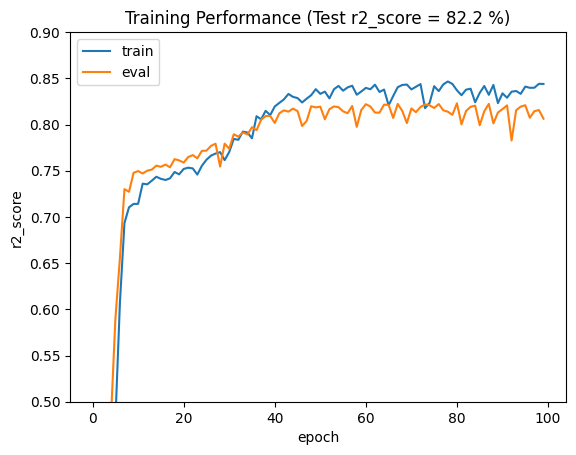

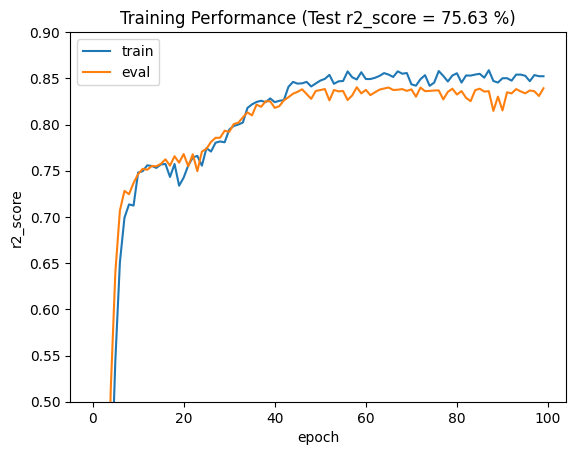

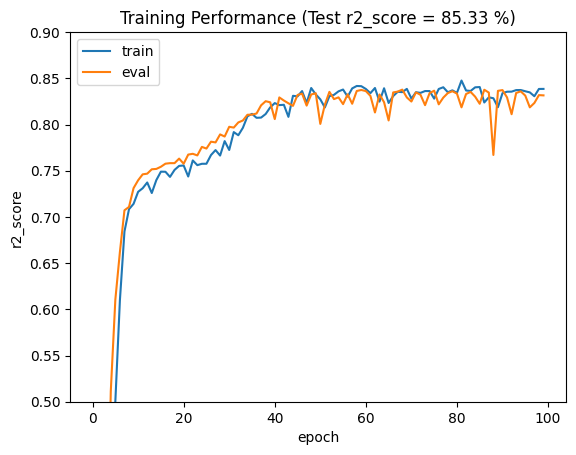

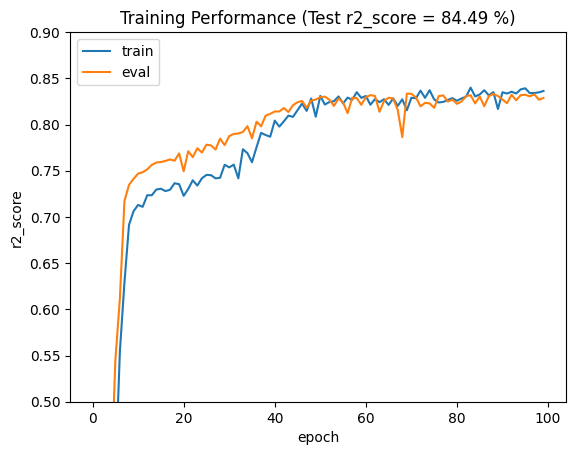

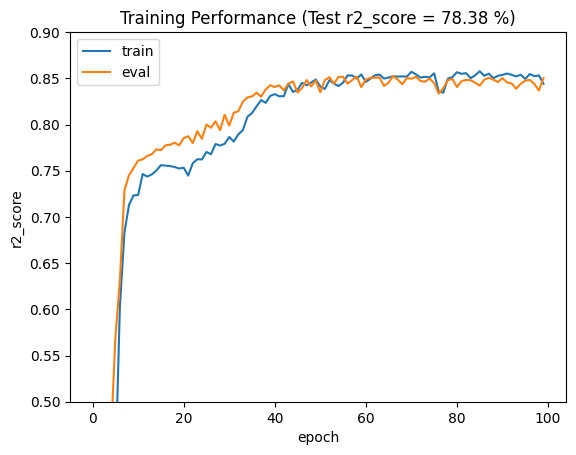

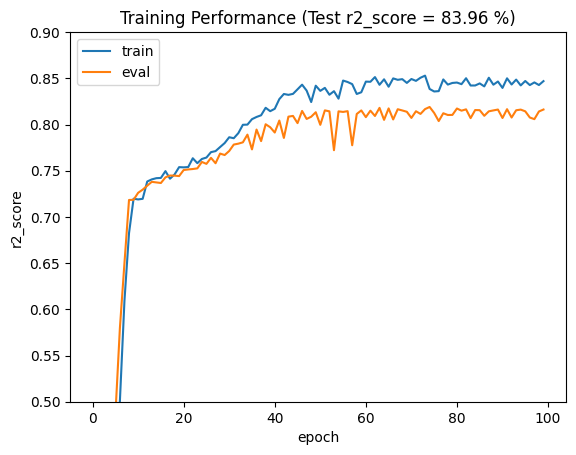

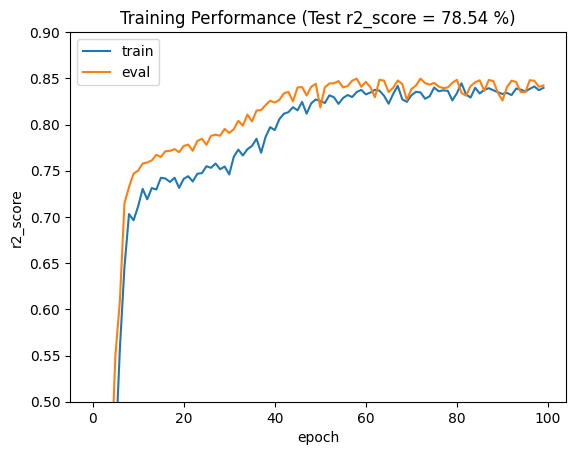

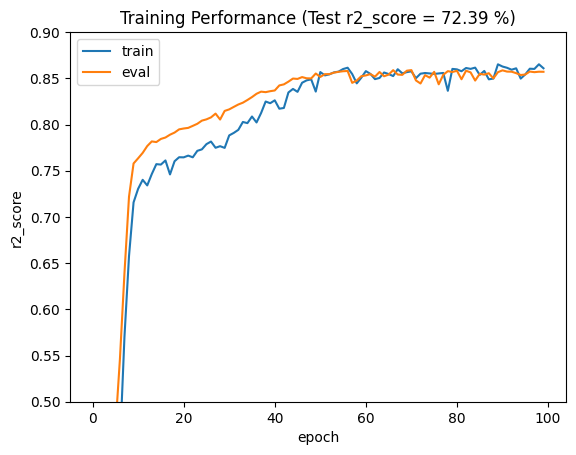

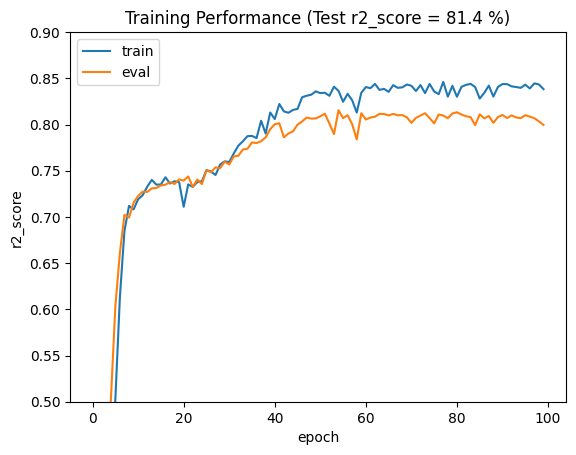

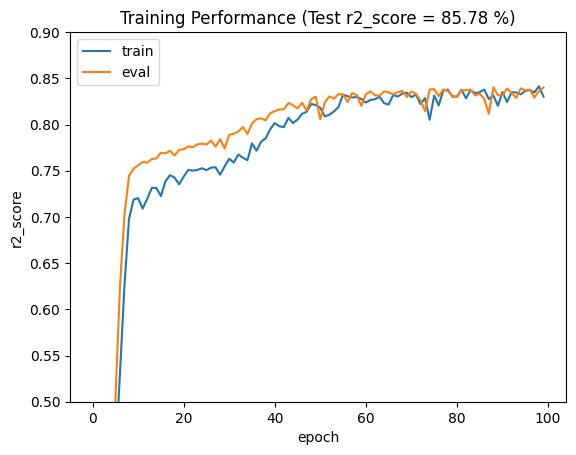

In [110]:
for ind in range(len(hists)):
  plot_perf(hists[ind], 'r2_score')
  plt.title('Training Performance (test r2_score = '+str(round(perfs[ind][2] * 100, 2))+ " %)")
  plt.ylim([0.5, 0.9])
  plt.show()